# 1) Libraries import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import seaborn as sns
from tqdm.contrib import tenumerate  # Uniquement tenumerate pour le suivi de progression
import joblib

# For traditional ML models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# For feature extraction and data augmentation
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# Check for GPU availability
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2) Data Loading

In [2]:
# Mount Google Drive if in Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/Colab_Notebooks/Project_6/Flipkart/Images/"
    os.chdir(path)
    print("Google Drive mounted successfully")
except:
    print("Not running in Colab or Drive already mounted")

# Load data
Flipkart = pd.read_csv('../flipkart_com-ecommerce_sample_1050.csv', encoding='iso-8859-1')
dataset = Flipkart[['product_category_tree', 'image']].copy()

Mounted at /content/drive
Google Drive mounted successfully


# 3) Categories management

In [3]:
# Rename categories for simplicity
shorten = {
    'Watches ': 'Watches',
    'Computers ': 'Computers',
    'Home Decor & Festive Needs ': 'Decor',
    'Kitchen & Dining ': 'Kitchen',
    'Home Furnishing ': 'Furniture',
    'Beauty and Personal Care ': 'Beauty',
    'Baby Care ': 'Baby'
}

# Extract categories from the product tree
dataset['category'] = dataset.product_category_tree.apply(lambda s: s[2:s.find('>>')])
dataset['category'] = dataset['category'].replace(shorten)

# Display category distribution
cat = pd.DataFrame(dataset.category.value_counts())
cat.reset_index(inplace=True)
cat.columns = ['category', 'count']
cat

,category,count
0,Furniture,150
1,Baby,150
2,Watches,150
3,Decor,150
4,Kitchen,150
5,Beauty,150
6,Computers,150


In [4]:
# dictionaire pour ordinal encoding des noms de categories
# permatra de comparer avec les resultast du clustering
dico={cat.loc[i,'category']:i for i in cat.index}
dico_reverse={i:cat.loc[i,'category'] for i in cat.index}
display(dico)

# affectation à la colonne cat_code
dataset['cat_code']=dataset.category.map(dico)

# Essayer avec un transformer labelencoder pour encodage decodage

{'Furniture': 0,
 'Baby': 1,
 'Watches': 2,
 'Decor': 3,
 'Kitchen': 4,
 'Beauty': 5,
 'Computers': 6}

# 4) Verifying and filtering images

In [5]:
# Check for existing images
existing_images = []
for img_name in dataset['image']:
    if os.path.exists(img_name):
        existing_images.append(img_name)

print(f"Number of images found: {len(existing_images)}")
dataset = dataset[dataset['image'].isin(existing_images)].reset_index(drop=True)

Number of images found: 1050


# 5) Data Augmentation and Feature Extraction Functions


In [6]:
def create_augmentation_generator():
    """Create and return a data augmentation generator"""
    return ImageDataGenerator(
        rotation_range=20,       # Random rotation up to 20 degrees
        width_shift_range=0.2,   # Random horizontal shift up to 20% of width
        height_shift_range=0.2,  # Random vertical shift up to 20% of height
        shear_range=0.2,         # Random shear transformation up to 0.2 radians
        zoom_range=0.2,          # Random zoom from 0.8× to 1.2× (±20%)
        horizontal_flip=True,    # Random horizontal flipping
        brightness_range=[0.8, 1.2],  # Random brightness adjustment between 80% and 120%
        fill_mode='nearest'      # Fill empty pixels using nearest neighbor interpolation
    )
def augment_image(img_array, n_augmentations=5):
    """Generate augmented versions of an image"""
    datagen = create_augmentation_generator()
    augmented_images = []

    # Reshape for the generator
    x = img_array.reshape((1,) + img_array.shape)

    # Generate augmented images
    batch_count = 0
    for batch in datagen.flow(x, batch_size=1):
        augmented_images.append(batch[0])
        batch_count += 1
        if batch_count >= n_augmentations:
            break

    return augmented_images
def extract_features_with_augmentation(image_paths, labels, feature_extractor, preprocess_func,
                                      img_size=(224, 224), augment=True, n_augmentations=3):
    """
    Extract features from original images and their augmented versions
    Returns features array and corresponding labels
    """
    all_features = []
    all_labels = []

    # Create feature extractor model
    print(f"Creating feature extractor model: {feature_extractor.__name__}")
    feature_model = feature_extractor(weights='imagenet', include_top=False, pooling='avg')

    # Process each image with tenumerate for progress tracking
    for i, (img_path, label) in tenumerate(zip(image_paths, labels),
                                          total=len(image_paths),
                                          desc="Extracting features"):
        try:
            # Load image
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)

            # Extract features from original image
            x = np.expand_dims(img_array, axis=0)
            x = preprocess_func(x)
            feature = feature_model.predict(x, verbose=0)
            all_features.append(feature.flatten())
            all_labels.append(label)

            # Generate and process augmented images if requested
            if augment:
                augmented_images = augment_image(img_array, n_augmentations)
                for aug_img in augmented_images:
                    x_aug = np.expand_dims(aug_img, axis=0)
                    x_aug = preprocess_func(x_aug)
                    aug_feature = feature_model.predict(x_aug, verbose=0)
                    all_features.append(aug_feature.flatten())
                    all_labels.append(label)

        except Exception as e:
            print(f"\nError processing {img_path}: {e}")
            # Use zeros as features for problematic images
            if feature_model.output_shape:
                feature_size = feature_model.output_shape[1]
                all_features.append(np.zeros(feature_size))
                all_labels.append(label)

    return np.array(all_features), np.array(all_labels)

# 6) Data Splitting

In [7]:
# Split data into training and test sets
X = dataset['image']
y = dataset['category']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
)
print(f"Training data size: {len(X_train)}, Test data size: {len(X_test)}")

Training data size: 892, Test data size: 158


# 7) Feature Extraction with Data Augmentation


In [8]:
save_path = '../extracted_features'
os.makedirs(save_path, exist_ok=True)

VGG16

In [9]:
# Choose feature extractor (VGG16 or ResNet50)
feature_extractor = VGG16
preprocess_func = vgg_preprocess
print(f"Using {feature_extractor.__name__} as feature extractor")
# Number of augmentations per image
n_augmentations = 3
print(f"Generating {n_augmentations} augmented versions per training image")
# Extract features from training images with augmentation
print("Extracting features from training images with augmentation...")
X_train_features, y_train_augmented = extract_features_with_augmentation(
    X_train.values,
    y_train.values,
    feature_extractor,
    preprocess_func,
    augment=True,
    n_augmentations=n_augmentations
)
# Extract features from test images (no augmentation for test set)
print("Extracting features from test images (no augmentation)...")
X_test_features, y_test_confirmed = extract_features_with_augmentation(
    X_test.values,
    y_test.values,
    feature_extractor,
    preprocess_func,
    augment=False
)
print(f"Original training set: {len(X_train)} images")
print(f"Augmented training set: {len(X_train_features)} feature vectors")
print(f"Test set: {len(X_test_features)} feature vectors")
# Check if class distribution remains balanced
print("\nClass distribution in augmented training set:")
train_class_dist = pd.Series(y_train_augmented).value_counts().sort_index()
print(train_class_dist)

Using VGG16 as feature extractor
Generating 3 augmented versions per training image
Extracting features from training images with augmentation...
Creating feature extractor model: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting features:   0%|          | 0/892 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Extracting features from test images (no augmentation)...
Creating feature extractor model: VGG16


Extracting features:   0%|          | 0/158 [00:00<?, ?it/s]

Original training set: 892 images
Augmented training set: 3568 feature vectors
Test set: 158 feature vectors

Class distribution in augmented training set:
Baby         512
Beauty       512
Computers    508
Decor        508
Furniture    508
Kitchen      512
Watches      508
Name: count, dtype: int64


In [10]:
# Saving features extracted with VGG16
vgg16_features = {
    'X_train': X_train_features,
    'y_train': y_train_augmented,
    'X_test': X_test_features,
    'y_test': y_test_confirmed
}
vgg16_filename = f"{save_path}/VGG16_features.pkl"
joblib.dump(vgg16_features, vgg16_filename)
print(f"Caractéristiques VGG16 enregistrées dans {vgg16_filename}")
print(f"Forme des données: Train {X_train_features.shape}, Test {X_test_features.shape}")

# To avoid any confusion, we can rename the variables for the following
X_train_features_vgg16 = X_train_features
y_train_augmented_vgg16 = y_train_augmented
X_test_features_vgg16 = X_test_features
y_test_confirmed_vgg16 = y_test_confirmed

Caractéristiques VGG16 enregistrées dans ../extracted_features/VGG16_features.pkl
Forme des données: Train (3568, 512), Test (158, 512)


ResNet50

In [11]:
feature_extractor = ResNet50
preprocess_func = resnet_preprocess

print(f"Using {feature_extractor.__name__} as feature extractor")

# Number of augmentations per image
n_augmentations = 3
print(f"Generating {n_augmentations} augmented versions per training image")

# Extract features from training images with augmentation
print("Extracting features from training images with augmentation...")
X_train_features, y_train_augmented = extract_features_with_augmentation(
    X_train.values,
    y_train.values,
    feature_extractor,
    preprocess_func,
    augment=True,
    n_augmentations=n_augmentations
)

# Extract features from test images (no augmentation for test set)
print("Extracting features from test images (no augmentation)...")
X_test_features, y_test_confirmed = extract_features_with_augmentation(
    X_test.values,
    y_test.values,
    feature_extractor,
    preprocess_func,
    augment=False
)

print(f"Original training set: {len(X_train)} images")
print(f"Augmented training set: {len(X_train_features)} feature vectors")
print(f"Test set: {len(X_test_features)} feature vectors")

# Check if class distribution remains balanced
print("\nClass distribution in augmented training set:")
train_class_dist = pd.Series(y_train_augmented).value_counts().sort_index()
print(train_class_dist)

Using ResNet50 as feature extractor
Generating 3 augmented versions per training image
Extracting features from training images with augmentation...
Creating feature extractor model: ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting features:   0%|          | 0/892 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Extracting features from test images (no augmentation)...
Creating feature extractor model: ResNet50


Extracting features:   0%|          | 0/158 [00:00<?, ?it/s]

Original training set: 892 images
Augmented training set: 3568 feature vectors
Test set: 158 feature vectors

Class distribution in augmented training set:
Baby         512
Beauty       512
Computers    508
Decor        508
Furniture    508
Kitchen      512
Watches      508
Name: count, dtype: int64


In [12]:
# Saving features extracted with ResNet50
resnet50_features = {
    'X_train': X_train_features,
    'y_train': y_train_augmented,
    'X_test': X_test_features,
    'y_test': y_test_confirmed
}

resnet50_filename = f"{save_path}/ResNet50_features.pkl"
joblib.dump(resnet50_features, resnet50_filename)
print(f"Caractéristiques ResNet50 enregistrées dans {resnet50_filename}")
print(f"Forme des données: Train {X_train_features.shape}, Test {X_test_features.shape}")

# To avoid any confusion, we can rename the variables for the following
X_train_features_resnet50 = X_train_features
y_train_augmented_resnet50 = y_train_augmented
X_test_features_resnet50 = X_test_features
y_test_confirmed_resnet50 = y_test_confirmed

Caractéristiques ResNet50 enregistrées dans ../extracted_features/ResNet50_features.pkl
Forme des données: Train (3568, 2048), Test (158, 2048)


# 8) Model Training and Evaluation


In [13]:
# To load VGG16 features
vgg16_features = joblib.load(f"{save_path}/VGG16_features.pkl")
X_train_features_vgg16 = vgg16_features['X_train']
y_train_augmented_vgg16 = vgg16_features['y_train']
X_test_features_vgg16 = vgg16_features['X_test']
y_test_confirmed_vgg16 = vgg16_features['y_test']

# To load ResNet50 features
resnet50_features = joblib.load(f"{save_path}/ResNet50_features.pkl")
X_train_features_resnet50 = resnet50_features['X_train']
y_train_augmented_resnet50 = resnet50_features['y_train']
X_test_features_resnet50 = resnet50_features['X_test']
y_test_confirmed_resnet50 = resnet50_features['y_test']

In [14]:
len(X_train_features_vgg16)

3568

In [15]:
len(X_test_features_vgg16)

158

Parameters tuning

In [16]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Define models to test
models = {
    # 'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000), # can be long to perform or impossible if not using projection
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    # 'Gradient Boosting': GradientBoostingClassifier(random_state=42) # very long to perform
}

# Parameter grids for each model
param_grids = {
    # 'Logistic Regression': {
    #     'classifier__C': [0.01, 0.1, 1.0, 10.0],
    #     'classifier__solver': ['lbfgs', 'liblinear', 'saga'],
    #     'classifier__penalty': ['l2', 'l1', 'elasticnet', None],
    #     'classifier__class_weight': [None, 'balanced']
    # },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['rbf', 'linear']
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    # 'Gradient Boosting': {
    #     'classifier__n_estimators': [100, 200],
    #     'classifier__learning_rate': [0.01, 0.1],
    #     'classifier__max_depth': [3, 5],
    # }
}

Function

In [17]:
# Function to train and evaluate a model with cross-validation
def train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test, param_grid, n_splits=5):
    print(f"\nTraining {model_name} with {n_splits}-fold cross-validation...")

    # Create cross-validation object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', models[model_name])
    ])

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2  # Increased verbosity to show progress
    )

    # Fit GridSearchCV
    print(f"Finding best parameters for {model_name}...")
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best parameters: {best_params}")
    print(f"CV Accuracy: {grid_search.best_score_:.4f}")

    # Evaluate on test set
    print("Evaluating on test set...")
    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {test_acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=sorted(np.unique(y_train)),
        yticklabels=sorted(np.unique(y_train))
    )
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {model_name} (accuracy : {test_acc})')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png')
    plt.show()

    return best_model, test_acc

Training

- VGG16

Training models:   0%|          | 0/3 [00:00<?, ?it/s]


Starting training for: Random Forest (1/3)

Training Random Forest with 5-fold cross-validation...
Finding best parameters for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
CV Accuracy: 0.9109
Evaluating on test set...
Test accuracy: 0.8418

Classification Report:
              precision    recall  f1-score   support

        Baby       0.76      0.73      0.74        22
      Beauty       0.90      0.86      0.88        22
   Computers       0.90      0.83      0.86        23
       Decor       0.82      0.78      0.80        23
   Furniture       0.80      0.70      0.74        23
     Kitchen       0.79      1.00      0.88        22
     Watches       0.92      1.00      0.96        23

    accuracy                           0.84       158
   macro avg       0.84      0.84      0.84       158
weighted avg       0.84      0.84      0.84 

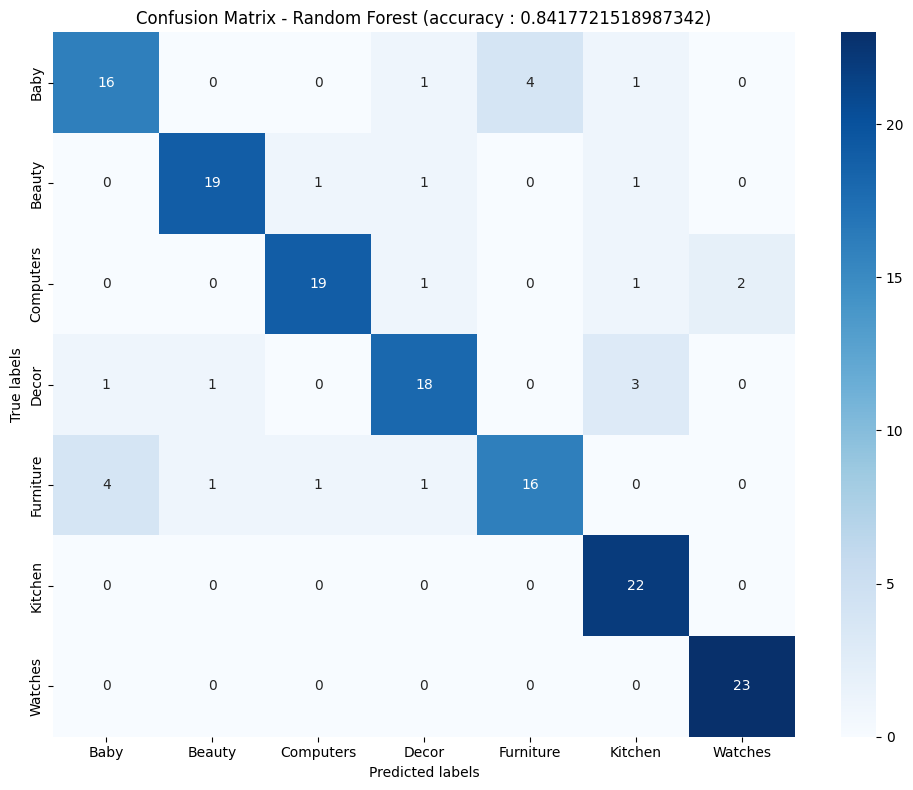

Saved model: ../extracted_features/vgg16_random_forest_model.pkl

Starting training for: SVM (2/3)

Training SVM with 5-fold cross-validation...
Finding best parameters for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
CV Accuracy: 0.9857
Evaluating on test set...
Test accuracy: 0.8354

Classification Report:
              precision    recall  f1-score   support

        Baby       0.79      0.68      0.73        22
      Beauty       0.89      0.77      0.83        22
   Computers       0.87      0.87      0.87        23
       Decor       0.78      0.91      0.84        23
   Furniture       0.75      0.78      0.77        23
     Kitchen       0.86      0.86      0.86        22
     Watches       0.92      0.96      0.94        23

    accuracy                           0.84       158
   macro avg       0.84      0.83      0.83       158
weighted avg       0.84    

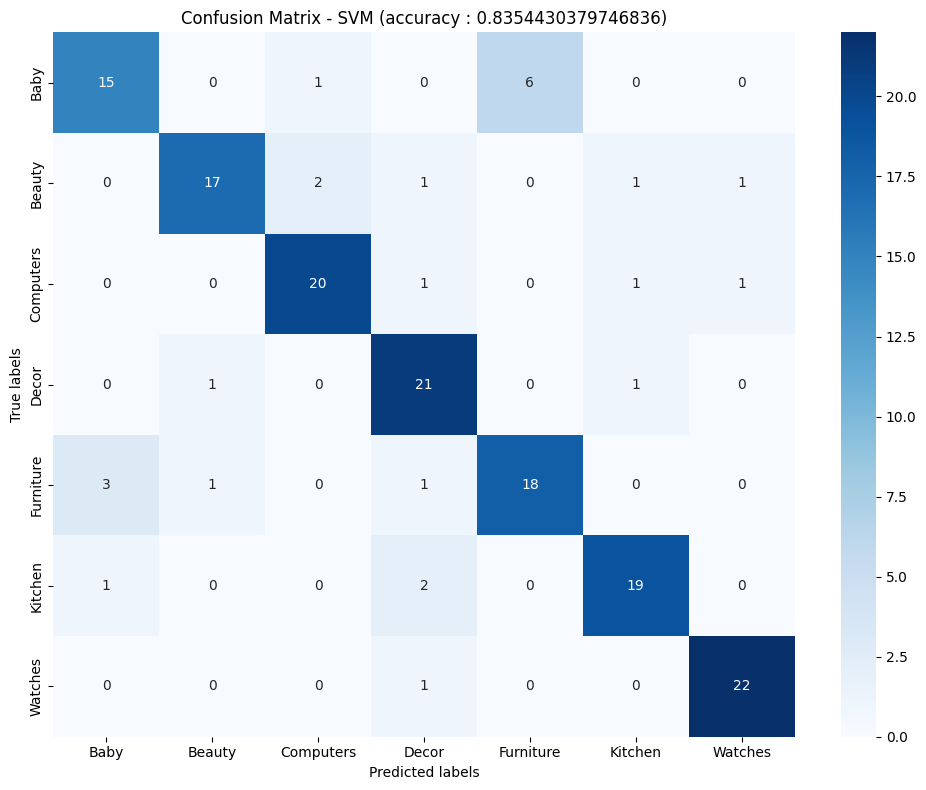

Saved model: ../extracted_features/vgg16_svm_model.pkl

Starting training for: KNN (3/3)

Training KNN with 5-fold cross-validation...
Finding best parameters for KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.96581258 0.97393976 0.91760384 0.94591009 0.85006266 0.90891448
        nan 0.9663728         nan 0.92152738        nan 0.86967797]
  warnings.warn(


Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
CV Accuracy: 0.9739
Evaluating on test set...
Test accuracy: 0.7089

Classification Report:
              precision    recall  f1-score   support

        Baby       0.56      0.64      0.60        22
      Beauty       0.85      0.77      0.81        22
   Computers       0.51      0.78      0.62        23
       Decor       0.86      0.52      0.65        23
   Furniture       0.69      0.48      0.56        23
     Kitchen       0.79      0.86      0.83        22
     Watches       0.88      0.91      0.89        23

    accuracy                           0.71       158
   macro avg       0.73      0.71      0.71       158
weighted avg       0.73      0.71      0.71       158



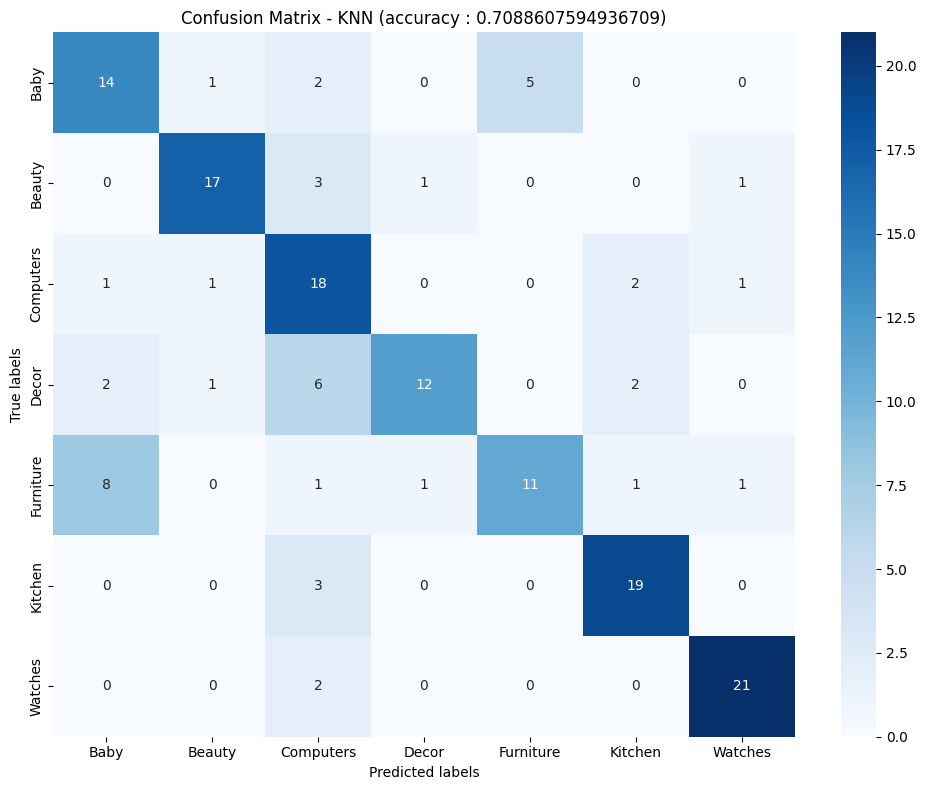

Saved model: ../extracted_features/vgg16_knn_model.pkl


In [18]:
# Train and evaluate each model
vgg16_results = {}
vgg16_best_models = {}
# Use tenumerate to track progress through models
for i, (model_name, param_grid) in tenumerate(param_grids.items(), desc="Training models"):
    print(f"\n{'='*50}")
    print(f"Starting training for: {model_name} ({i+1}/{len(param_grids)})")
    print(f"{'='*50}")

    best_model, test_acc = train_and_evaluate_model(
        model_name,
        X_train_features_vgg16,
        y_train_augmented_vgg16,
        X_test_features_vgg16,
        y_test_confirmed_vgg16,
        param_grid
    )
    vgg16_results['VGG16 '+ model_name] = test_acc
    vgg16_best_models['VGG16 ' + model_name] = best_model

    # Sauvegarder le modèle
    model_filename = f"{save_path}/vgg16_{model_name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(best_model, model_filename)
    print(f"Saved model: {model_filename}")

- ResNet50

Training models:   0%|          | 0/3 [00:00<?, ?it/s]


Starting training for: Random Forest (1/3)

Training Random Forest with 5-fold cross-validation...
Finding best parameters for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
CV Accuracy: 0.9098
Evaluating on test set...
Test accuracy: 0.8354

Classification Report:
              precision    recall  f1-score   support

        Baby       0.83      0.68      0.75        22
      Beauty       0.86      0.86      0.86        22
   Computers       0.86      0.83      0.84        23
       Decor       0.78      0.61      0.68        23
   Furniture       0.76      0.96      0.85        23
     Kitchen       0.80      0.91      0.85        22
     Watches       0.96      1.00      0.98        23

    accuracy                           0.84       158
   macro avg       0.84      0.84      0.83       158
weighted avg       0.84      0.84      0.83 

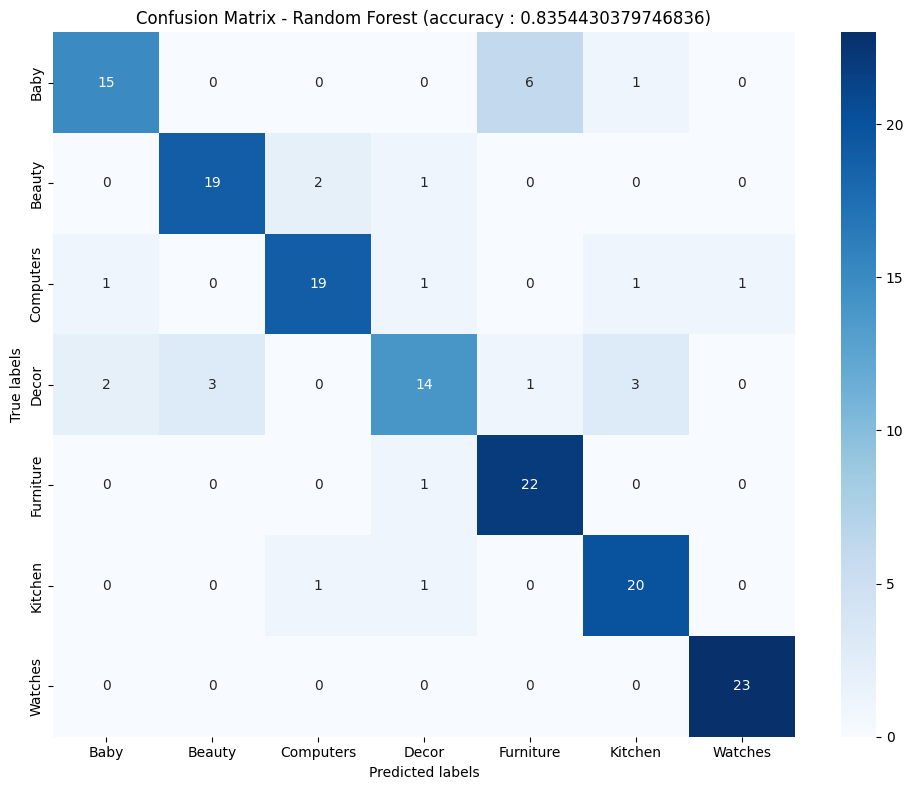

Saved model: ../extracted_features/resnet50_random_forest_model.pkl

Starting training for: SVM (2/3)

Training SVM with 5-fold cross-validation...
Finding best parameters for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
CV Accuracy: 0.9896
Evaluating on test set...
Test accuracy: 0.8608

Classification Report:
              precision    recall  f1-score   support

        Baby       0.75      0.68      0.71        22
      Beauty       0.86      0.82      0.84        22
   Computers       0.88      0.91      0.89        23
       Decor       0.77      0.87      0.82        23
   Furniture       0.81      0.91      0.86        23
     Kitchen       1.00      0.91      0.95        22
     Watches       1.00      0.91      0.95        23

    accuracy                           0.86       158
   macro avg       0.87      0.86      0.86       158
weighted avg       0.87 

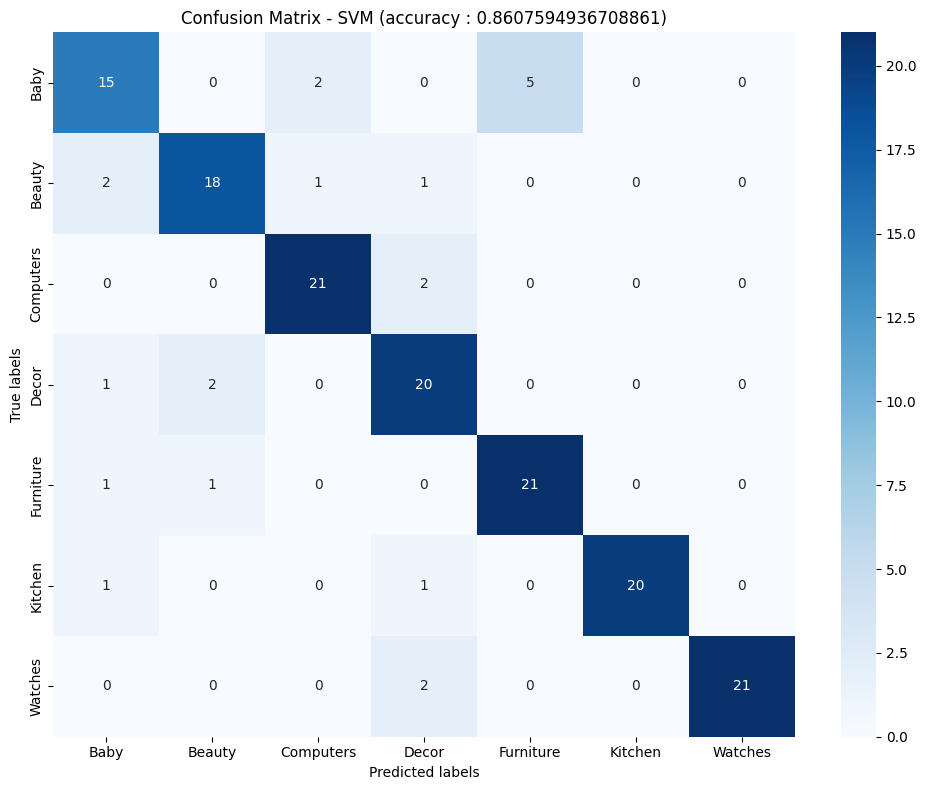

Saved model: ../extracted_features/resnet50_svm_model.pkl

Starting training for: KNN (3/3)

Training KNN with 5-fold cross-validation...
Finding best parameters for KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.97870127 0.985708   0.94282729 0.96272663 0.90246994 0.94394852
        nan 0.98290609        nan 0.9635654         nan 0.94450717]
  warnings.warn(


Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
CV Accuracy: 0.9857
Evaluating on test set...
Test accuracy: 0.8544

Classification Report:
              precision    recall  f1-score   support

        Baby       0.76      0.73      0.74        22
      Beauty       0.76      0.86      0.81        22
   Computers       0.84      0.91      0.88        23
       Decor       1.00      0.70      0.82        23
   Furniture       0.86      0.83      0.84        23
     Kitchen       0.91      0.95      0.93        22
     Watches       0.88      1.00      0.94        23

    accuracy                           0.85       158
   macro avg       0.86      0.85      0.85       158
weighted avg       0.86      0.85      0.85       158



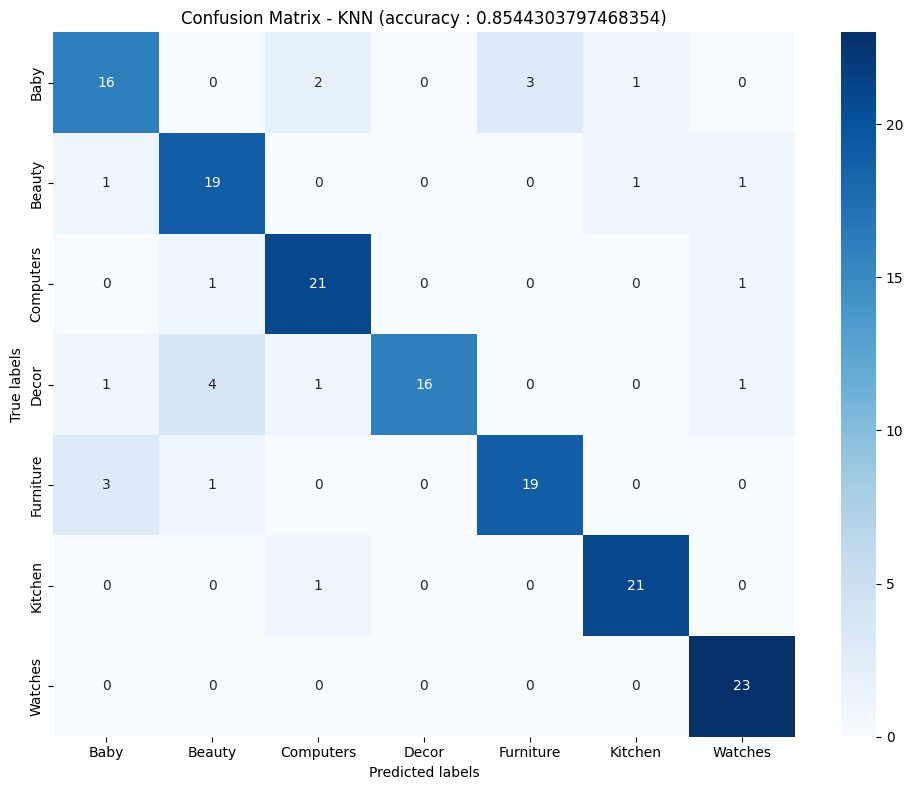

Saved model: ../extracted_features/resnet50_knn_model.pkl


In [19]:
# Train and evaluate each model
resnet50_results = {}
resnet50_best_models = {}
# Use tenumerate to track progress through models
for i, (model_name, param_grid) in tenumerate(param_grids.items(), desc="Training models"):
    print(f"\n{'='*50}")
    print(f"Starting training for: {model_name} ({i+1}/{len(param_grids)})")
    print(f"{'='*50}")

    best_model, test_acc = train_and_evaluate_model(
        model_name,
        X_train_features_resnet50,
        y_train_augmented_resnet50,
        X_test_features_resnet50,
        y_test_confirmed_resnet50,
        param_grid
    )
    resnet50_results['ResNet50 ' + model_name] = test_acc
    resnet50_best_models['ResNet50 ' + model_name] = best_model

    # Sauvegarder le modèle
    model_filename = f"{save_path}/resnet50_{model_name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(best_model, model_filename)
    print(f"Saved model: {model_filename}")

- Saving performances

In [20]:
# Combine results
all_results = {**vgg16_results, **resnet50_results}
# Save combined results
combined_results_filename = f"{save_path}/../combined_model_results.pkl"
joblib.dump(all_results, combined_results_filename)
print(f"Résultats combinés sauvegardés: {combined_results_filename}")
# Afficher un tableau de comparaison des résultats
results_df = pd.DataFrame([
    {'Model': model_name, 'Accuracy': acc}
    for model_name, acc in all_results.items()
]).sort_values('Accuracy', ascending=False)
print("\nRésumé des performances de tous les modèles:")
print(results_df)

Résultats combinés sauvegardés: ../extracted_features/../combined_model_results.pkl

Résumé des performances de tous les modèles:
                    Model  Accuracy
4            ResNet50 SVM  0.860759
5            ResNet50 KNN  0.854430
0     VGG16 Random Forest  0.841772
1               VGG16 SVM  0.835443
3  ResNet50 Random Forest  0.835443
2               VGG16 KNN  0.708861


# 9) Compare results


In [21]:
# Load combined results
all_results = joblib.load(f"{save_path}/combined_model_results.pkl")
# Create a DataFrame with all results
results_df = pd.DataFrame([
    {'Model': model_name,
     'Clean Model Name': model_name.replace('VGG16 ', '').replace('ResNet50 ', ''),
     'Feature Extractor': 'VGG16' if 'VGG16' in model_name else 'ResNet50',
     'Accuracy': acc}
    for model_name, acc in all_results.items()
])

# Pivot the DataFrame to display VGG16 and ResNet50 side by side
pivot_df = results_df.pivot(index='Clean Model Name', columns='Feature Extractor', values='Accuracy')
# Add a difference column
pivot_df['Difference'] = pivot_df['ResNet50'] - pivot_df['VGG16']


In [22]:
def highlight_cells(val, df):
    """
    Colorie les cellules selon leur valeur :
    - Maximum entre ResNet50 et VGG16 en vert
    - Minimum entre ResNet50 et VGG16 en rouge clair
    - Différences positives en vert clair
    - Différences négatives en rouge clair
    """
    if pd.isna(val):
        return ''

    # Traitement spécial pour la colonne de différence
    if 'Difference' in df.columns:
        if df.columns[-1] == 'Difference' and df.iloc[:, -1].equals(pd.Series([val])):
            if val > 0:
                return 'background-color: lightgreen'
            elif val < 0:
                return 'background-color: lightcoral'
            return ''

    # Ne considérer que les colonnes ResNet50 et VGG16 pour le max/min
    model_cols = [col for col in df.columns if col in ['ResNet50', 'VGG16']]

    if len(model_cols) > 0:
        all_values = df[model_cols].values.flatten()
        max_val = max(all_values)
        min_val = min(all_values)

        if val == max_val:
            return 'background-color: green; color: white; font-weight: bold'
        elif val == min_val:
            return 'background-color: lightcoral'

    return ''

def format_model_comparison(df, format_as_percent=True):
    """
    Formate un DataFrame de comparaison de modèles avec surlignage
    des valeurs max/min et des différences
    """
    # Créer une copie pour éviter les modifications sur l'original
    styled_df = df.copy()

    # Appliquer le formatage
    if format_as_percent:
        format_dict = {col: '{:.2%}' for col in df.columns}
    else:
        format_dict = {col: '{:.4f}' for col in df.columns}

    return styled_df.style.applymap(lambda x: highlight_cells(x, df)).format(format_dict)

# Exemple d'utilisation
# styled_results = format_model_comparison(pivot_df, format_as_percent=False)
# display(styled_results)

In [23]:
# Pour votre pivot_df actuel (VGG16 vs ResNet50)
styled_pivot = format_model_comparison(pivot_df, format_as_percent=False)
display(styled_pivot)


<ipython-input-22-af42055a197a>:50: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  return styled_df.style.applymap(lambda x: highlight_cells(x, df)).format(format_dict)


Feature Extractor,ResNet50,VGG16,Difference
Clean Model Name,,,
KNN,0.8354,0.7215,0.1139
Random Forest,0.8481,0.8354,0.0127
SVM,0.8608,0.8165,0.0443


<Figure size 1500x800 with 0 Axes>

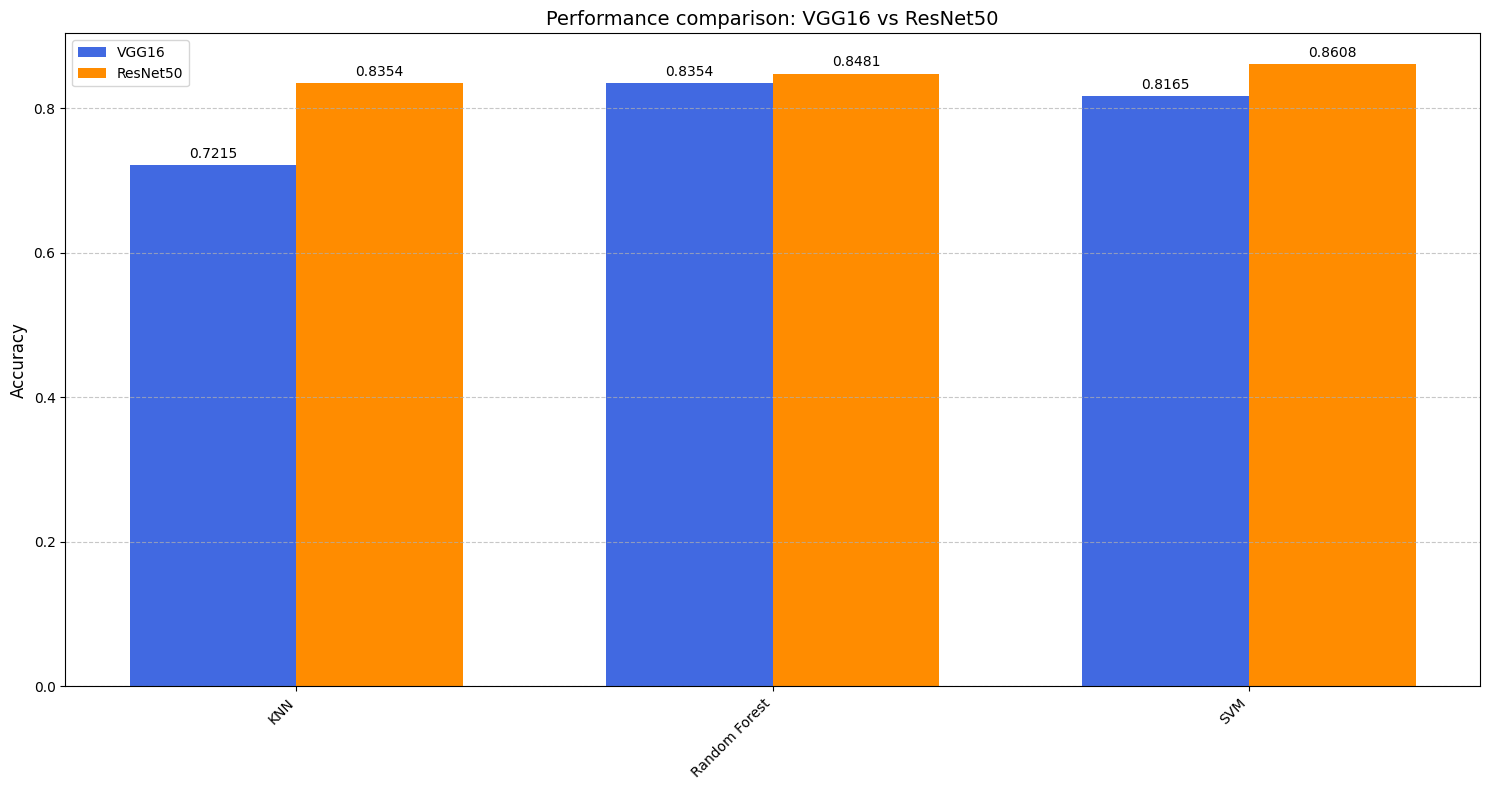

In [24]:
# Créer également la visualisation graphique
plt.figure(figsize=(15, 8))
models_list = pivot_df.index.tolist()
# Créer le graphique à barres groupées
x = np.arange(len(models_list))
width = 0.35
fig, ax = plt.subplots(figsize=(15, 8))
rects1 = ax.bar(x - width/2, pivot_df['VGG16'], width, label='VGG16', color='royalblue')
rects2 = ax.bar(x + width/2, pivot_df['ResNet50'], width, label='ResNet50', color='darkorange')
# Ajouter des étiquettes, un titre et une légende
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Performance comparison: VGG16 vs ResNet50', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
# Ajouter les valeurs sur les barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.savefig(f"{save_path}/model_comparison_grouped.png")
plt.show()

In [25]:
# Identify the best global model
best_model_row = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nBest overall model: {best_model_row['Model']}")
print(f"Accuracy: {best_model_row['Accuracy']:.4f}")
# Create a summary of the best models by extractor
best_by_extractor = results_df.loc[results_df.groupby('Feature Extractor')['Accuracy'].idxmax()]
print("\nBest models by feature extractor:")
print(best_by_extractor[['Feature Extractor', 'Model', 'Accuracy']].to_string(index=False))
# Display performance distribution by extractor
print("\nPerformance distribution:")
print(results_df.groupby('Feature Extractor')['Accuracy'].agg(['min', 'max', 'mean', 'std']).round(4))


Best overall model: ResNet50 SVM
Accuracy: 0.8608

Best models by feature extractor:
Feature Extractor               Model  Accuracy
         ResNet50        ResNet50 SVM  0.860759
            VGG16 VGG16 Random Forest  0.835443

Performance distribution:
                      min     max    mean     std
Feature Extractor                                
ResNet50           0.8354  0.8608  0.8481  0.0127
VGG16              0.7215  0.8354  0.7911  0.0610


In [26]:
best_model_row

,4
Model,ResNet50 SVM
Clean Model Name,SVM
Feature Extractor,ResNet50
Accuracy,0.860759


# 10) Load the best model

In [27]:
# Trouver le modèle avec la meilleure accuracy
best_model_name = max(all_results, key=all_results.get)
best_accuracy = all_results[best_model_name]

best_model_path = f"{save_path}/{best_model_name.replace(' ', '_').lower()}_model.pkl"

print(f"\nBest model : {best_model_name} with an accuracy of {best_accuracy:.4f}")


Best model : ResNet50 SVM with an accuracy of 0.8608


In [28]:
best_model = joblib.load(best_model_path)
print(f"Loaded model from {best_model_path}")

Loaded model from ../extracted_features/resnet50_svm_model.pkl


In [29]:
best_model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', SVC(C=10, probability=True, random_state=42))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': SVC(C=10, probability=True, random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__C': 10,
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifier__class_weight': None,
 'classifier__coef0': 0.0,
 'classifier__decision_function_shape': 'ovr',
 'classifier__degree': 3,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'rbf',
 'classifier__max_iter': -1,
 'classifier__probability': True,
 'classifier__random_state': 42,
 'classifier__shrinking': True,
 'classifier__tol': 0.001,
 'classifier__verbose': False}

# 11) Function to predict on new images


In [30]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

In [31]:
images_folder_path = '../../test_images/'
images_paths = os.listdir(images_folder_path)
images_paths

['RIDEAU-OCCULTANT-UNI.png',
 'vezuvio-tasse-a-cafe-2.jpg',
 'PC-de-bureau-Asus-Pro-D340MF.jpg',
 'mic-wired-dpa-handle-black.jpg',
 'meuble-2-tiroirs-2-portes.jpg',
 'creme-visage-anti-age.webp']

In [32]:
def predict_image_category(image_path, model, feature_extractor, preprocess_func, img_size=(224, 224)):
    """
    Predict the category of a new image using the trained model
    """
    # Extract features from the image
    print(f"Processing image: {image_path}")
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    x = np.expand_dims(img_array, axis=0)
    x = preprocess_func(x)

    # Use the feature extractor
    feature_model = feature_extractor(weights='imagenet', include_top=False, pooling='avg')
    features = feature_model.predict(x, verbose=0)

    # Reshape for prediction
    features = features.reshape(1, -1)

    # Predict
    prediction = model.predict(features)

    return prediction[0]

In [33]:
# For some scikit-learn models
if hasattr(best_model, 'classes_'):
    classes = best_model.classes_
    print("Classes prédites par le modèle:", classes)


Classes prédites par le modèle: ['Baby' 'Beauty' 'Computers' 'Decor' 'Furniture' 'Kitchen' 'Watches']


In [34]:
predicted_categories = []
for image_path in images_paths:
  predicted_categories.append(predict_image_category(images_folder_path + image_path, best_model, ResNet50, resnet_preprocess, img_size=(224, 224)))

Processing image: ../../test_images/RIDEAU-OCCULTANT-UNI.png
Processing image: ../../test_images/vezuvio-tasse-a-cafe-2.jpg
Processing image: ../../test_images/PC-de-bureau-Asus-Pro-D340MF.jpg
Processing image: ../../test_images/mic-wired-dpa-handle-black.jpg


Processing image: ../../test_images/meuble-2-tiroirs-2-portes.jpg


Processing image: ../../test_images/creme-visage-anti-age.webp


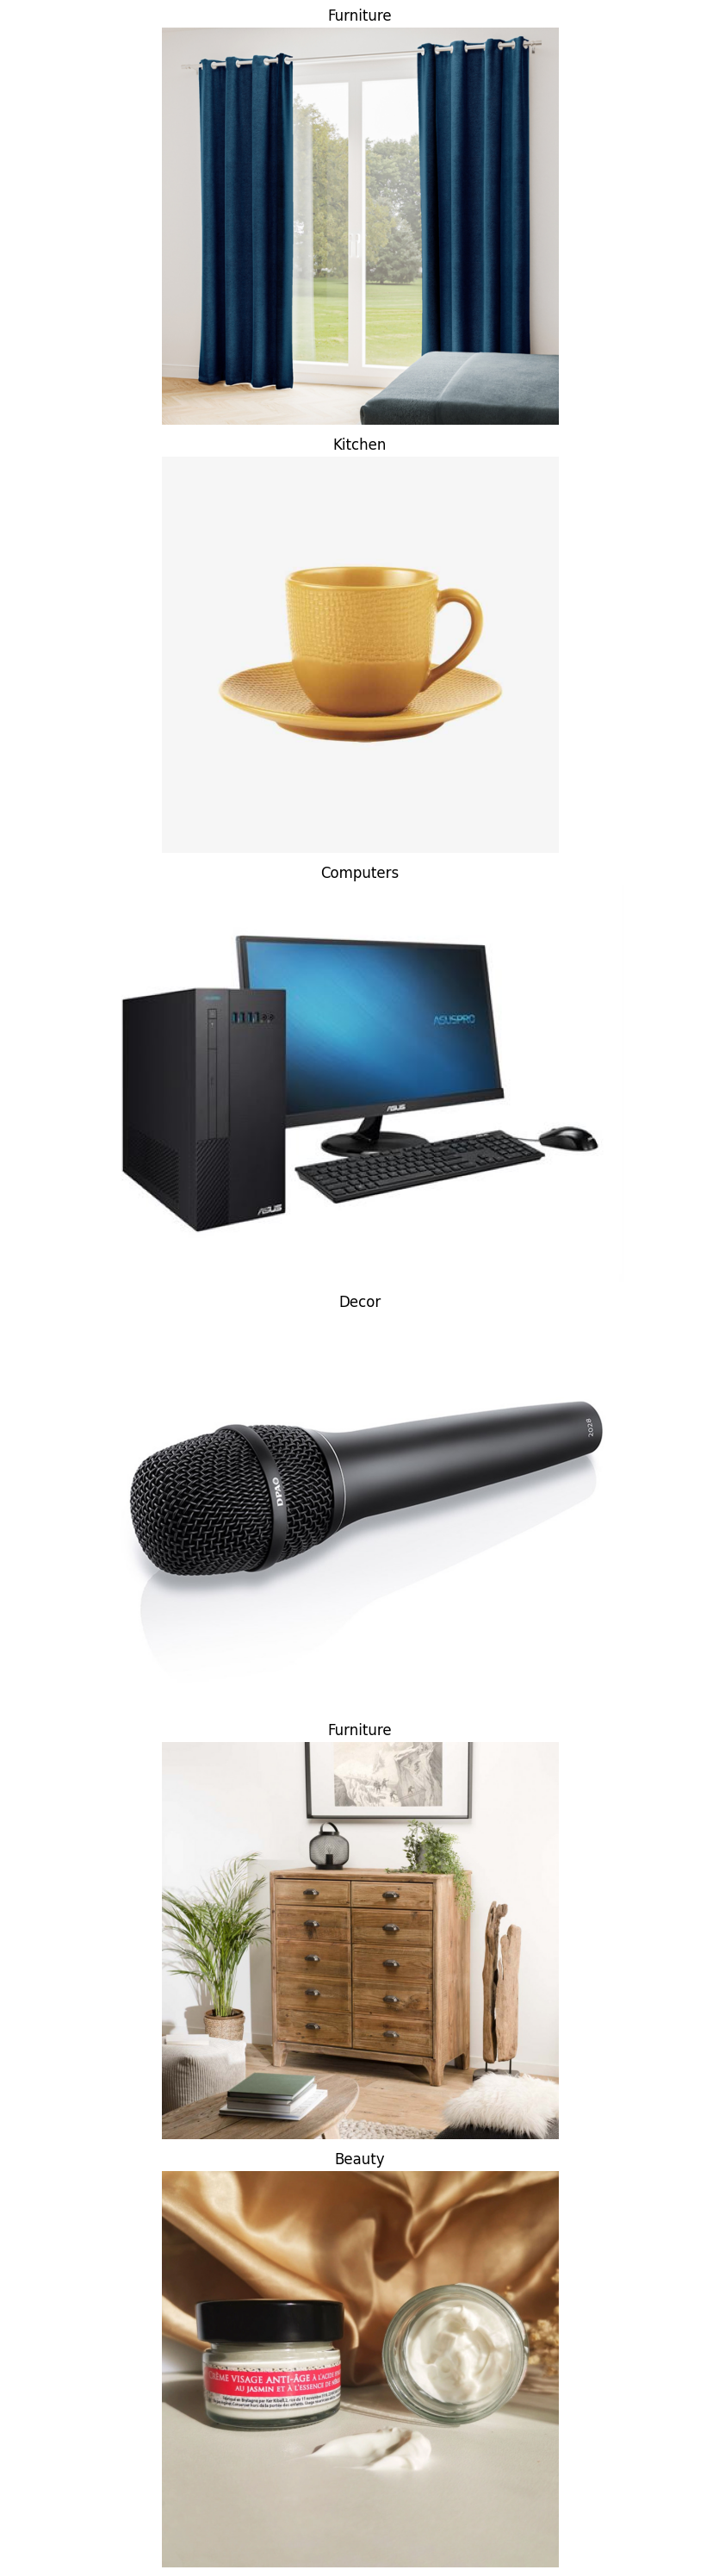

In [35]:
# Display images with predicted categories
import matplotlib.pyplot as plt
# Number of images per line
cols = 1
rows = (len(images_paths) + cols - 1) // cols
plt.figure(figsize=(15, 5 * rows))
for i, (image_path, category) in enumerate(zip(images_paths, predicted_categories)):
    plt.subplot(rows, cols, i + 1)
    img = plt.imread(images_folder_path + image_path)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.tight_layout()
plt.show()